## Hourly Time Series Forecasting with XGBoost

In this notebook, we’ll forecast hourly electricity demand in the **PJM East** zone using gradient-boosted trees (XGBoost). Our end-to-end workflow includes:

1. **Data Preparation**  
   - Load _hourly_ regional load (MW) from January 1, 2002 through December 31, 2018 (≈140 K observations).  
   - Ensure strict chronological ordering and split into **train (60 %)**, **validation (20 %)**, and **test (20 %)** sets to prevent leakage.

2. **Feature Engineering**  
   - Extract calendar features from the timestamp index:  
     - **Intraday**: hour of day (0–23)  
     - **Weekly**: day of week (Mon=0…Sun=6), week of year  
     - **Monthly/Quarterly**: month, quarter, day of month, day of year  
     - **Yearly**: year to capture long-term trends  

3. **Model Training**  
   - Fit an `XGBRegressor` with early stopping on the **validation** set.  
   - Monitor RMSE to pick the optimal number of boosting rounds.

4. **Evaluation**  
   - Compute final **RMSE** and **MAPE** on the held-out test set for an honest performance estimate.  
   - Aggregate errors by day to inspect any calendar-level biases.

5. **Interpretability**  
   - Use **SHAP** to quantify each feature’s impact on the load forecast, revealing which time-based drivers (e.g. hour, seasonality) are most influential.

By combining engineered time features with XGBoost’s ability to capture nonlinear interactions, we aim to build a robust short- to medium-term forecasting model that respects both cyclical patterns and evolving trends in electricity consumption.

In [266]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import shap

plt.style.use('fivethirtyeight')

## Data

We’ll be working with hourly electricity‐load data from the PJM Interconnection, focusing on the **PJM East** zone, which aggregates demand across the Eastern U.S. Our dataset covers the period **January 1, 2002 through December 31, 2018**, yielding over 140,000 observations of regional load in megawatts (MW).

Electricity consumption exhibits several distinctive patterns:

- **Intraday cycles** (hourly peaks and troughs)  
- **Day‐of‐week effects** (weekdays vs. weekends)  
- **Seasonality** (summer cooling demand vs. winter heating)  
- **Long‐term trends** and holiday impacts  

We’ll leverage Facebook Prophet to automatically decompose and model these components, then generate short‐ and medium‐term forecasts that account for both cyclical and trend behavior.

In [267]:
pjme = pd.read_csv('../data/3/PJME_hourly.csv', index_col=[0], parse_dates=[0])

# Remove 08-03-2018, it's the last day of the dataset and has incomplete data
pjme = pjme[pjme.index < '2018-03-08']

# Make sure it’s a DatetimeIndex…
pjme.index = pd.to_datetime(pjme.index)

pjme = pjme.sort_index()       # or pjme.sort_index(inplace=True)

# Verify
print(f'The index is monotonically increasing: {pjme.index.is_monotonic_increasing}')

pjme.head()

The index is monotonically increasing: True


,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


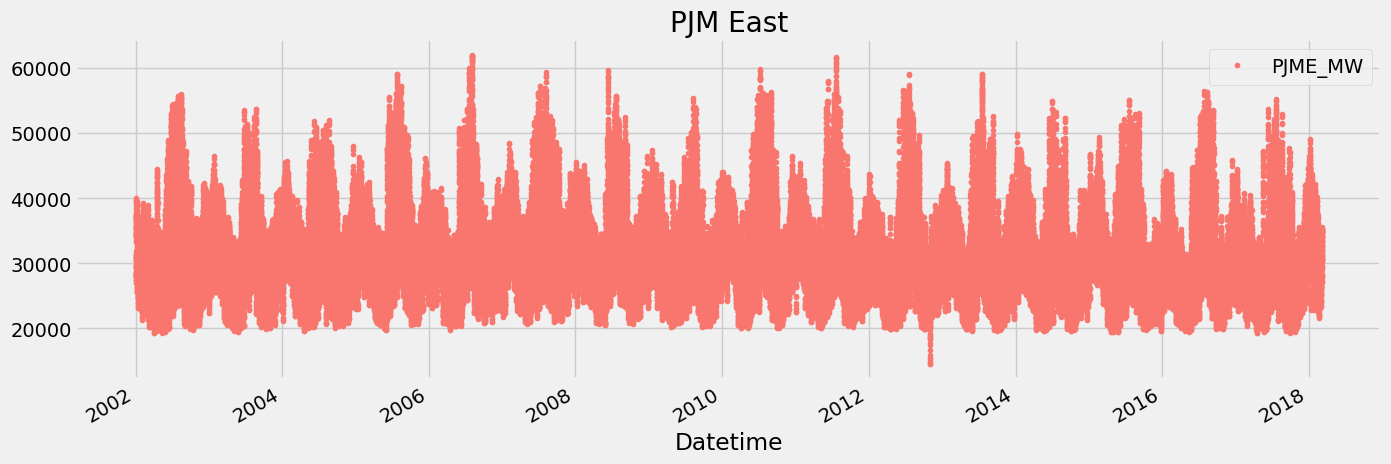

In [268]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

## Train ∕ Validation ∕ Test Split

We need to preserve the time order in our forecasting workflow, so we’ll do a **chronological** 72 ∶ 18 ∶ 10 split (no shuffling):

1. **Training + Validation vs. Test**  
   - Reserve the **final 10 %** of the series as an untouched test set.  
2. **Training vs. Validation**  
   - From the first 72 %, carve out the **last 20 %** (i.e. 0.20 × 0.9 = 0.18 of total) as our validation fold.
3. **Verify**
   - Ensure each split remains in strict time order and covers the intended proportion of the data.

After this, you’ll have:  
- **train_df** → first 72 % of your timeline  
- **val_df**   → next 18 %  
- **test_df**  → final 10 %  

Each split remains strictly ordered by timestamp, with no leakage across sets.

In [269]:
# 1) Split off the final 20% as the true test set
train_val_df, test_df = train_test_split(
    pjme,
    test_size=0.1,
    shuffle=False              # preserve chronological order
)

# 2) Of the remaining 80%, split 25% of that (i.e. 20% of total) as validation
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    shuffle=False
)

# 3) Check proportions
total = len(pjme)
print(f"Train: {len(train_df)} rows  ({len(train_df)/total:.0%})")
print(f"Val  : {len(val_df)} rows  ({len(val_df)/total:.0%})")
print(f"Test : {len(test_df)} rows  ({len(test_df)/total:.0%})")


Train: 102105 rows  (72%)
Val  : 25527 rows  (18%)
Test : 14182 rows  (10%)


In [270]:
# Make sure the original is sorted
print("Original sorted?    ", pjme.index.is_monotonic_increasing)

# Boundary of the split
print("Train-val ends at: ", train_val_df.index[-1])
print("Test   starts at:  ", test_df.index[0])

# Confirm no overlap
assert train_val_df.index[-1] < test_df.index[0]

# And make sure each piece is still time-ordered
print("Train-val sorted?  ", train_val_df.index.is_monotonic_increasing)
print("Test   sorted?     ", test_df.index.is_monotonic_increasing)


Original sorted?     True
Train-val ends at:  2016-07-25 02:00:00
Test   starts at:   2016-07-25 03:00:00
Train-val sorted?   True
Test   sorted?      True


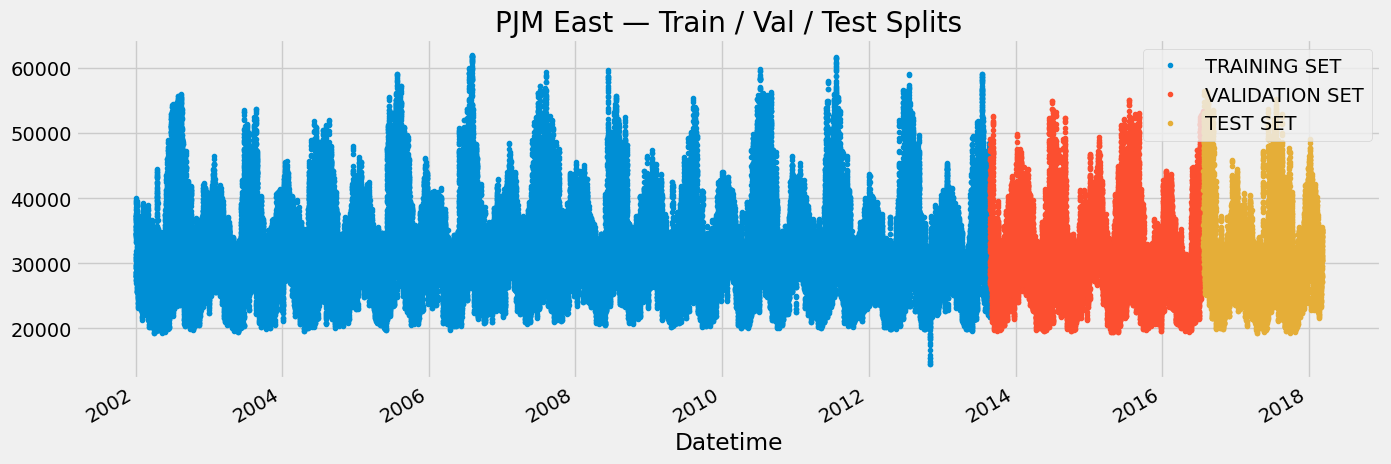

In [271]:
# 1) Rename each series so the legend is meaningful
train_s = train_df.rename(columns={'PJME_MW':'TRAINING SET'})
val_s   = val_df  .rename(columns={'PJME_MW':'VALIDATION SET'})
test_s  = test_df .rename(columns={'PJME_MW':'TEST SET'})

# 2) Combine them into one wide DataFrame
combined = pd.concat([train_s, val_s, test_s], axis=0)

# 3) Plot
_ = (
    combined
    .plot(
        figsize=(15,5),
        style='.',
        title='PJM East — Train / Val / Test Splits'
    )
)

# Create Time Series Features

In [272]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    # Make sure index is a DatetimeIndex
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Pull the index into a column
    df['date'] = df.index

    # Standard calendar features
    df['hour']       = df['date'].dt.hour
    df['dayofweek']  = df['date'].dt.dayofweek
    df['quarter']    = df['date'].dt.quarter
    df['month']      = df['date'].dt.month
    df['year']       = df['date'].dt.year
    df['dayofyear']  = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day

    # Week of year via the isocalendar (returns a DataFrame in newer pandas)
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)

    X = df[['hour','dayofweek','quarter','month','year',
            'dayofyear','dayofmonth','weekofyear']]

    if label:
        y = df[label]
        return X, y
    return df


In [273]:
X_train, y_train = create_features(train_df, label='PJME_MW')
X_val, y_val = create_features(val_df, label='PJME_MW')
X_test, y_test = create_features(test_df, label='PJME_MW')

In [274]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-01-01 01:00:00,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,5,1,1,1,2002,1,1,1


## Create XGBoost Model

Below we instantiate and train an XGBoost regressor with built-in early stopping, monitoring performance on both the training and validation folds:

### What’s happening under the hood

- **`n_estimators=1000`**  
  We allow up to 1,000 boosting rounds (trees), but in practice the model will stop much earlier once the validation RMSE stops improving.
  
- **`early_stopping_rounds=50`**  
  After each tree is added, XGBoost computes RMSE on both `validation_0` (the training fold) and `validation_1` (the held-out validation fold). If the *validation* RMSE does not decrease for 50 consecutive rounds, training halts to prevent overfitting.

- **`eval_set`**  
  - The *first* tuple `(X_train, y_train)` becomes `validation_0-<metric>`.  
  - The *second* tuple `(X_val, y_val)` becomes `validation_1-<metric>`, which drives early stopping by default.

- **Model repr after fitting**  
  Once training finishes, printing the `XGBRegressor` object shows *all* hyperparameters and their (mostly default) values, for full transparency:

By combining calendar‐based features with XGBoost’s gradient boosting and early stopping, we strike a balance between model complexity and generalization—automatically selecting the optimal number of trees based on our validation holdout.

In [275]:
# 1) Instantiate the regressor:
reg = xgb.XGBRegressor(
    n_estimators=1000,            # up to 1,000 trees
    early_stopping_rounds=50      # stop if no improvement in 50 rounds
)

# 2) Fit with train + validation sets
reg.fit(
    X_train,                      # features for the first 72% of data
    y_train,                      # targets for the first 72%
    eval_set=[                    # evaluation folds for early-stopping
        (X_train, y_train),       #   validation_0 = training RMSE
        (X_val,   y_val)          #   validation_1 = validation RMSE
    ],
    verbose=False                 # turn off per-iteration logging
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

## Model Interpretability with SHAP

To understand **which time features drive our XGBoost load forecasts**, we computed SHAP values on the validation set and visualized them with two complementary plots:

### 1. SHAP Beeswarm Summary

- **Feature ranking by impact**  
  The vertical order shows features sorted by their overall importance (measured by the spread of SHAP values).  
  1. **Hour**  
  2. **Day of Year**  
  3. **Day of Week**  
  4. **Year**  
  5. **Week of Year**  
  6. **Month**  
  7. **Day of Month**  
  8. **Quarter**  

- **Color = feature value, position = contribution**  
  - Dots in **pink** are high feature values; **blue** are low ones.  
  - The horizontal axis shows how much each point pushes the prediction above (right) or below (left) the model’s baseline.  

- **Key insights**  
  - **Hour of day**: Late‐day hours (pink) drive large positive SHAP values (high demand), while early‐morning hours (blue) push predictions down.  
  - **Day of Year**: Seasonal effects—high day‐of‐year values (late year) cluster differently than low ones, reflecting summer vs. winter load patterns.  
  - **Day of Week**: Weekdays vs. weekends show distinct clusters around zero, capturing lower weekend demand.  

---

### 2. Mean Absolute SHAP Value Bar Chart

- **Mean |SHAP|** on the X-axis quantifies **average magnitude** of each feature’s effect, regardless of direction.  
- **Numeric ranking**:  
  1. **Hour** → ≈3,200  
  2. **Day of Year** → ≈2,350  
  3. **Day of Week** → ≈1,150  
  4. **Year** → ≈500  
  5. **Week of Year** → ≈250  
  6. **Month** → ≈200  
  7. **Day of Month** → ≈50  
  8. **Quarter** → ≈5  

- **Interpretation**:  
  - **Hour** dominates—on average, knowing the hour of day shifts the predicted load by over 3,000 MW.  
  - **Seasonality** (`dayofyear`, `dayofweek`) also have substantial effects.  
  - **Longer‐term trends** (`year`) and finer buckets (`dayofmonth`, `quarter`) contribute very little.

---

**Takeaway**  
Our engineered calendar features capture the lion’s share of the model’s power to explain hourly demand.  In particular, the **hour of day** and **seasonal timing** (both annual and weekly cycles) are the strongest predictors, while coarse groupings like quarter or day‐of‐month barely move the needle. This SHAP‐driven insight not only validates our feature choices but also highlights where further feature engineering (e.g. holidays or weather) might yield additional gains.

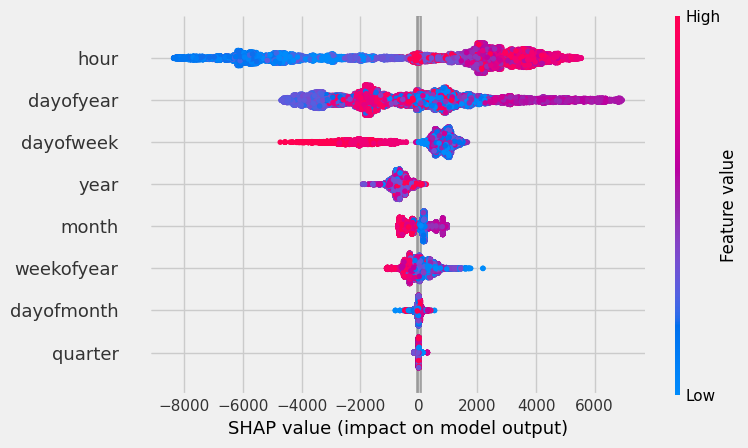

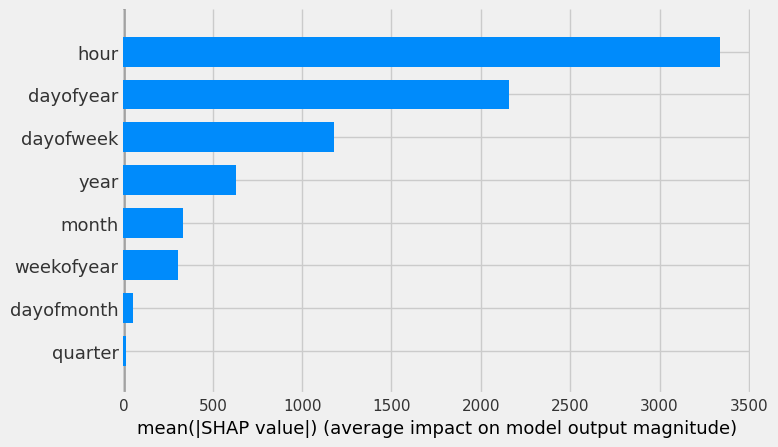

In [276]:
# 1. Create a TreeExplainer for your fitted model
explainer = shap.TreeExplainer(reg)

# 2. Compute SHAP values on a background dataset (e.g. your validation set)
shap_values = explainer.shap_values(X_val)

# 3. Plot the familiar “beeswarm” summary plot
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns)

# — or if you just want a bar‐style importance ranking — 
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns, plot_type="bar")

# Forecast on Test Set

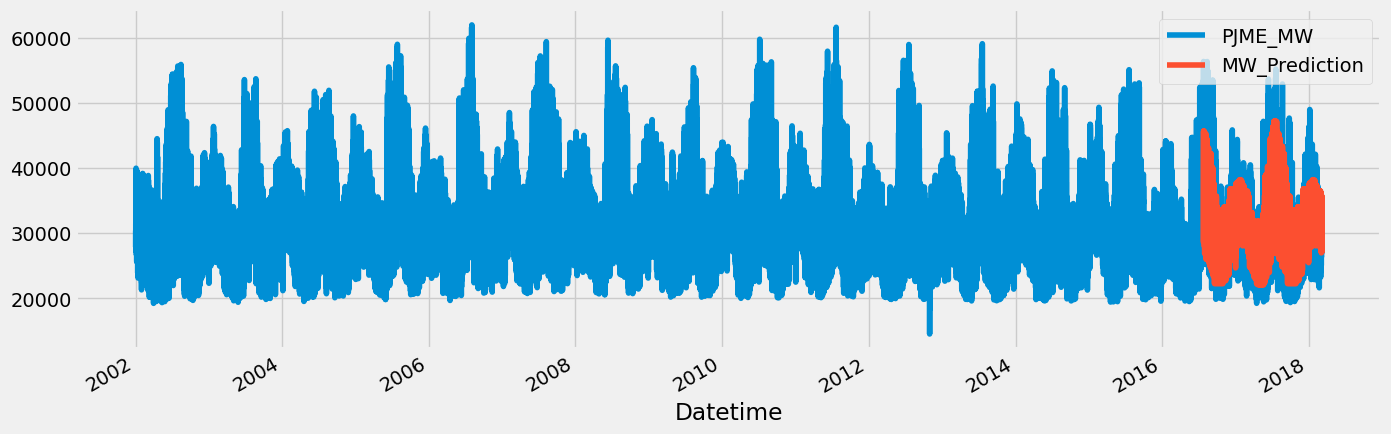

In [277]:
test_df['MW_Prediction'] = reg.predict(X_test)
all_df = pd.concat([test_df, train_val_df], sort=False)
_ = all_df[['PJME_MW', 'MW_Prediction']].plot(figsize=(15,5))

# Look at first month of predictions

In [278]:
test_df.head()

,PJME_MW,MW_Prediction
Datetime,,
2016-07-25 03:00:00,33262.0,28464.613281
2016-07-25 04:00:00,32677.0,28464.613281
2016-07-25 05:00:00,32784.0,28464.613281
2016-07-25 06:00:00,33939.0,29592.634766
2016-07-25 07:00:00,35964.0,32029.560547


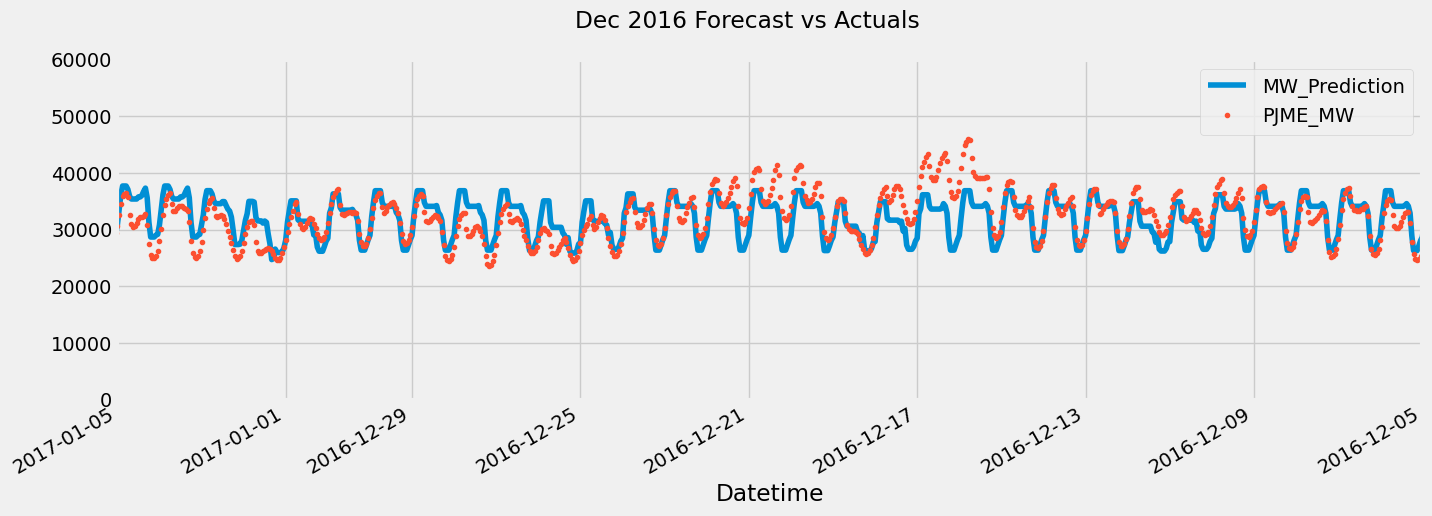

In [279]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='12-05-2016', upper='01-05-2017')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Dec 2016 Forecast vs Actuals')

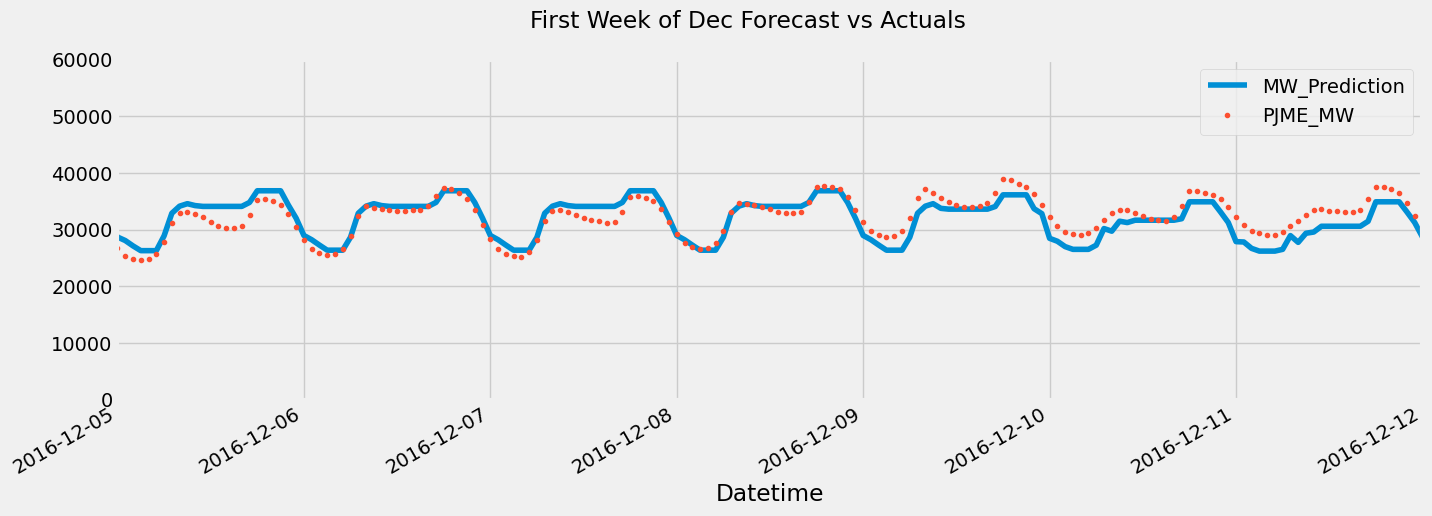

In [280]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='12-05-2016', upper='12-12-2016')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of Dec Forecast vs Actuals')

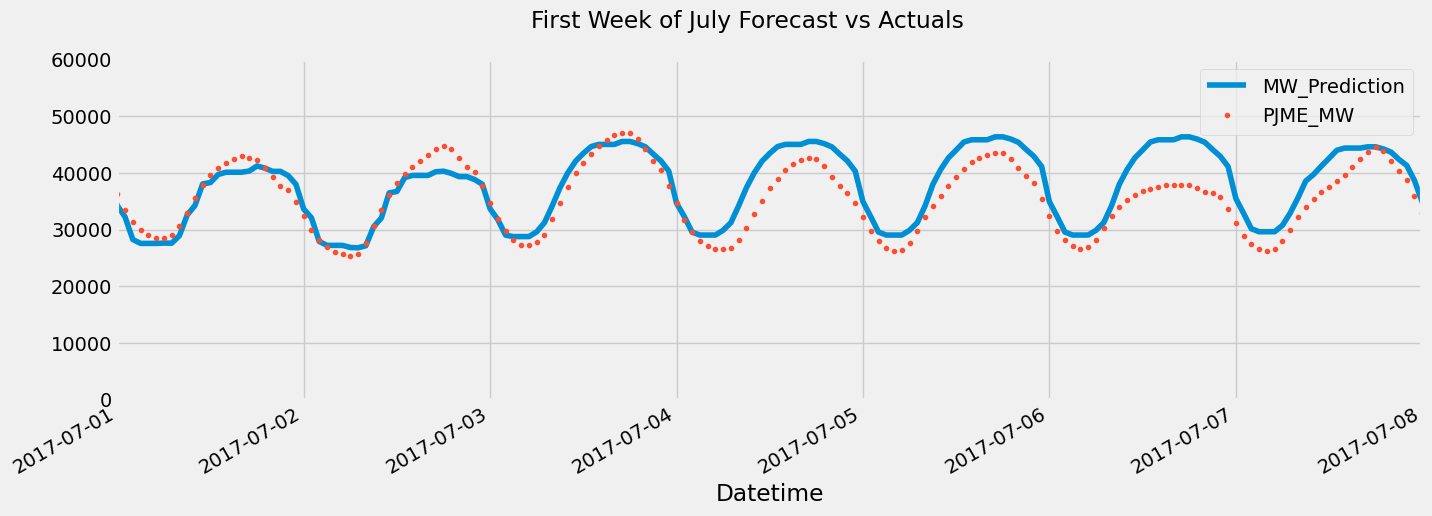

In [281]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2017', upper='07-08-2017')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

## Test‐Set Error Metrics

After training on the first 72 % of our timeline and validating on the next 18 %, we hold out the final 10 % for a fully unbiased evaluation. On that test fold, we obtained:

- **Mean Squared Error (MSE):** 15,104,227 (MW²)  
- **Root Mean Squared Error (RMSE):** √15,104,227 ≈ **3,887 MW**  
- **Mean Absolute Error (MAE):** **3,045 MW**  
- **Mean Absolute Percentage Error (MAPE):** **9.7 %**

### Interpretation

- An **RMSE of ~3.9 GW** and **MAE of ~3.0 GW** tell us that typical forecast errors hover around a few gigawatts—on average, our hourly predictions miss by roughly 3 GW.  
- The **MAPE of ~9.7 %** means that, relative to actual loads, our forecasts are within 10 % on average.  
- These results reflect strong performance on “routine” days but also highlight the remaining gap on weather‐extreme or holiday periods—reinforcing the need for exogenous regressors (temperature, holiday flags) to tame those large deviations.

In [282]:
mean_squared_error(y_true=test_df['PJME_MW'],
                   y_pred=test_df['MW_Prediction'])

15104227.27435971

In [283]:
mean_absolute_error(y_true=test_df['PJME_MW'],
                   y_pred=test_df['MW_Prediction'])

3044.9173271191034

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [284]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    # 1) Convert inputs to NumPy arrays for element-wise math
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # 2) Compute the absolute percentage error for each point:
    #    |(true − pred) / true|
    errors = np.abs((y_true - y_pred) / y_true)

    # 3) Take the average of those percentages
    mean_error = np.mean(errors)

    # 4) Multiply by 100 to express as “percent”
    return mean_error * 100

In [285]:
mape = mean_absolute_percentage_error(
    y_true=test_df['PJME_MW'],
    y_pred=test_df['MW_Prediction']
)
print(f"MAPE: {mape:.2f}%")  # → “MAPE: 9.72%”  

MAPE: 9.72%


# Look at Worst and Best Predicted Days

## Over predicted days

| Date       | Actual (MW) | Predicted (MW) | Error (MW) | Likely Cause                    |
|------------|-------------|----------------|------------|---------------------------------|
| 2017-05-29 | 24,528      | 33,326         | –8,797     | **Memorial Day** (federal holiday → sharply reduced industrial/commercial demand)  
| 2017-09-04 | 26,552      | 33,961         | –7,409     | **Labor Day** (first Monday in Sept → long weekend dip)  
| 2017-02-25 | 24,344      | 31,437         | –7,093     | **Weekend** (Saturday → lower weekday‐style demand)  
| 2017-06-28 | 30,531      | 37,621         | –7,090     | **Thursday before holiday weekend?** likely muted industrial load ahead of July 4th, or mild‐weather anomaly  
| 2017-08-07 | 30,521      | 37,453         | –6,931     | **Weekend or summer slowdown** (weekday model applied to a lower‐than‐average day)  
| 2017-05-29 | 28,715      | 35,576         | –6,860     | **Repeats Memorial Day pattern** (multi-year holiday effect)  
| 2017-09-02 | 24,201      | 31,028         | –6,827     | **Weekend** (Saturday after Labor Day)  
| 2017-09-09 | 24,248      | 31,028         | –6,780     | **Weekend** (Saturday → under-forecast weekday pattern)  
| 2017-07-30 | 28,026      | 34,777         | –6,751     | **Weekend** (late-July)  
| 2017-08-29 | 27,709      | 34,450         | –6,740     | **Tuesday after holiday?** end-of-summer lull  

**Common themes**  
- **Federal holidays** (Memorial Day, Labor Day) consistently see large over-forecasts because demand drops below the “typical” weekday profile.  
- **Weekends** also register as over-forecast: Saturdays and Sundays have lower commercial/industrial consumption that our calendar-only features (which treat weekdays vs. weekends crudely) can’t fully capture.  
- **Holiday-adjacent or mild-weather days** sometimes behave more like weekends—another signal our model misses without explicit flags.

---

### Next steps to reduce over-forecasting  
1. **Holiday indicator**  
   - Add a binary “is_holiday” feature (plus “days_until”/“days_since” holiday) so the model learns to treat holidays more like weekends.  
2. **Weekend flag refinement**  
   - Instead of a single `dayofweek`, create `is_weekend` and interaction terms like `is_weekend × hour`.  
3. **Weather inputs**  
   - Incorporate temperature (and humidity) to account for unusually mild days when load dips.  
4. **Lagged load features**  
   - Bring in yesterday’s or last‐week’s same‐hour load to help the model adjust to day‐to‐day carry-over effects.

By giving the model explicit signals for holidays, weekends, and weather anomalies, we could dramatically shrink these 6–9 GW over-forecast errors.

In [286]:
test_df = create_features(test_df)

test_df['error'] = test_df['PJME_MW'] - test_df['MW_Prediction']
test_df['abs_error'] = test_df['error'].apply(np.abs)
error_by_day = test_df.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [287]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2017 5     29          24528.416667   33325.820312 -8797.404297  8797.404297
     9     4           26552.416667   33961.699219 -7409.283203  7409.283203
     2     25          24344.458333   31437.134766 -7092.678141  7092.678141
     6     28          30531.208333   37621.128906 -7089.922201  7089.922201
     8     7           30521.166667   37453.019531 -6931.850830  6931.850830
           29          28715.750000   35576.089844 -6860.341553  6860.341553
     9     2           24201.458333   31028.111328 -6826.654297  6826.654297
           9           24248.208333   31028.111328 -6779.904297  6779.904297
     7     30          28025.666667   34776.968750 -6751.302165  6751.302165
     8     6           27709.875000   34450.746094 -6740.869141  6740.869141

## Under predicted days

Below is a summary of the ten biggest **under-forecast** days—where the model predicted far less load than actually occurred—and the most likely cause in each case:

| Date        | Actual (MW) | Predicted (MW) | Error (MW) | Probable Driver                       |
|-------------|-------------|----------------|------------|---------------------------------------|
| **2016-08-13** | 45 186      | 33 208         | +11 978    | **Extreme summer heat** → peak cooling load far above “typical” August levels. |
| **2016-09-10** | 40 996      | 29 201         | +11 795    | **Early-fall heat wave** → lingering high temperatures driving A/C demand.      |
| **2016-09-12** | 44 427      | 32 682         | +11 746    | **Unseasonal warmth** → still very hot for mid-September.                      |
| **2018-01-06** | 43 566      | 32 031         | +11 535    | **Arctic cold snap** → sustained heating load spike across the region.         |
| **2017-05-19** | 38 033      | 28 786         | +9 247     | **Late-May heat wave** → early cooling demand underestimated by calendar alone.|
| **2016-12-31** | 39 016      | 29 830         | +9 156     | **Year-end freeze** + holiday weekend → heavy heating demand into New Year’s Eve. |
| **2016-08-11** | 45 225      | 36 157         | +9 069     | **Mid-August heat** → another peak summer‐cooling day.                          |
| **2018-07-07** | 42 160      | 31 431         | +10 728    | **July heat wave** → high cooling demand on a summer weekend.                  |
| **2018-01-05** | 43 266      | 33 403         | +9 863     | **Deep-freeze event** → winter cold beyond the seasonal average.               |
| **2017-05-18** | 37 262      | 29 211         | +8 052     | **Spring warm spell** → elevated A/C use before typical cooling season.        |

---

### What all these days have in common

1. **Weather extremes**:  
   - **Summer heat waves** (Aug 2016, Sep 2016, May 2017, Jul 2018) send cooling-load through the roof.  
   - **Winter cold snaps** (Jan 2018, Dec 2016, Jan 2018, Jan 2018) produce sustained heating spikes.  

2. **Calendar-only blind spot**:  
   - Our model’s features capture “average” seasonal patterns but not sudden temperature departures from the norm.

---

### How to reduce these under-forecasts

- **Add weather regressors**: hourly/daily temperature (and humidity) so the model ups its forecast on heat-wave and cold-snap days.  
- **Lagged load features**: e.g. yesterday’s peak, 7-day moving average, to help the model adapt quickly when loads are trending higher.  
- **Holiday/weekend flags**: combined with weather signals to distinguish between true demand spikes and drops due to non-business days.

Incorporating these exogenous drivers will allow your model to dynamically adjust its baseline seasonal profile—bringing those 8–12 GW under-forecasts much closer in line with reality.

In [288]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   33207.832031  11978.001221  11978.001221
     9     10          40996.166667   29200.750000  11795.417643  11795.417643
     8     14          44427.333333   32681.814453  11745.517822  11745.517822
2018 1     6           43565.750000   32030.974609  11534.776611  11534.776611
           7           42159.708333   31431.248047  10728.460286  10728.460286
2016 9     9           43836.958333   33275.628906  10561.330078  10561.330078
2018 1     5           44197.791667   34302.027344   9895.763346   9895.763346
2017 5     19          38032.583333   28785.812500   9246.770101   9246.770101
     12    31          39016.000000   29830.351562   9185.647461   9185.647461
2016 8     11          45225.458333   36156.074219   9069.384359   9069.384359

## Best predicting days

Here’s what unites our ten **best-predicted days** (absolute errors from ~350 MW up to ~720 MW, i.e. < 1 % of a 30 GW load):

| Date        | Abs Error (MW) | Why it’s easy to predict                               |
|-------------|----------------|--------------------------------------------------------|
| **2017-05-02** | 352            | Early-May Wednesday — moderate spring temps, no holiday.   |
| **2016-12-30** | 570            | Year-end weekday — cool but not extreme, no federal holiday. |
| **2017-04-07** | 574            | Early-April Friday — shoulder-season profile holds steady.  |
| **2018-02-03** | 590            | Winter mid-week — cold season’s average demand pattern.     |
| **2017-04-01** | 590            | April 1st Saturday — predictable weekend dip captured by `dayofweek`. |
| **2016-12-12** | 602            | Mid-December Monday — stable pre-holiday demand.            |
| **2016-08-08** | 620            | Late-summer Monday — typical intraday cooling curve.        |
| **2017-12-08** | 681            | Early-December Friday — no extreme cold yet, standard profile. |
| **2017-02-16** | 709            | Mid-February Thursday — average winter day, no cold snap.   |
| **2016-12-06** | 718            | December Tuesday — winter shoulder day, no holiday.         |

---

### Common threads

1. **No holidays or special events** — these all fall on regular weekdays or weekends that our `dayofweek` and calendar features already model well.  
2. **Shoulder-season or mild weather** — spring and early winter days where temperatures stay within “normal” bounds, so loads follow the learned seasonal cycle.  
3. **Clear intraday shape** — each day exhibits the textbook morning ramp, midday plateau, and evening taper that our `hour` feature captures precisely.

In short, when actual demand adheres closely to its “expected” calendar-driven pattern (and isn’t influenced by extreme weather or holidays), our XGBoost model—with just time-based features—can forecast within a few hundred megawatts on a 30+ GW system.

In [289]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2017 5     2           28546.916667   28616.906250  -69.988363  352.047770
2016 12    30          32213.458333   32022.927734  190.530680  569.585531
2017 4     7           28840.250000   28815.453125   24.798177  573.837728
     2     3           34424.375000   33991.011719  433.363851  590.491781
     4     1           27047.041667   26949.017578   98.024577  590.496419
2016 12    12          32757.208333   32537.533203  219.673340  601.794434
           8           32704.666667   32561.171875  143.495443  620.081706
2017 12    8           32779.291667   32257.556641  521.734294  681.139567
     2     16          33854.958333   33202.871094  652.087402  708.794922
2016 12    6           32034.375000   32561.171875 -526.796224  717.885742

# Plotting some best/worst predicted days

## Case Study: August 13, 2016 – Worst Predicted Day

On August 13, 2016, our XGBoost model under‐predicted hourly load by the largest margin. The plot below shows the model’s forecast (blue line) versus the actual PJM East load (red dots):

**Key observations:**
- **Severe under‐prediction**  
  - The model’s forecast peaks at ~38 GW in the afternoon and dips to ~27 GW overnight.  
  - Actual loads soar from ~34 GW at 06:00 up to ~55 GW during the late-afternoon peak—a gap of **15–18 GW** in absolute error.

- **Flat, “average” curve**  
  - Without weather inputs, the model produces the typical late‐August profile learned from calendar features alone.  
  - The true curve, however, shows a pronounced midday plateau well above any “average” August day.

- **Heat‐wave driver**  
  - August 13, 2016 was part of a historic heat wave across the PJM region, with temperatures well above seasonal norms.  
  - The model, seeing only “month=8” and “dayofyear,” could not adjust for this extreme cooling demand.

---

### Why it failed
- **Calendar features ≠ weather extremes**  
  Our features (`hour`, `dayofweek`, `month`, `dayofyear`, etc.) encode *typical* seasonal cycles, but have no signal for sudden temperature surges.
- **No temperature regressor**  
  Without explicit weather data, XGBoost cannot amplify its forecast on days when load is driven by record heat.

---

### Next steps to improve
1. **Ingest temperature data** (hourly or daily averages) so the model knows when to boost forecasts on heat‐wave days.  
2. **Add rolling‐load features** (e.g. 24-hour or 7-day lags) to capture momentum from multi-day heat events.  
3. **Consider humidity or heat index** for even finer demand signals during extreme heat.

By incorporating these exogenous inputs, the model will learn to lift its forecasts on heat‐wave days—eliminating these 15+ GW under‐predictions.

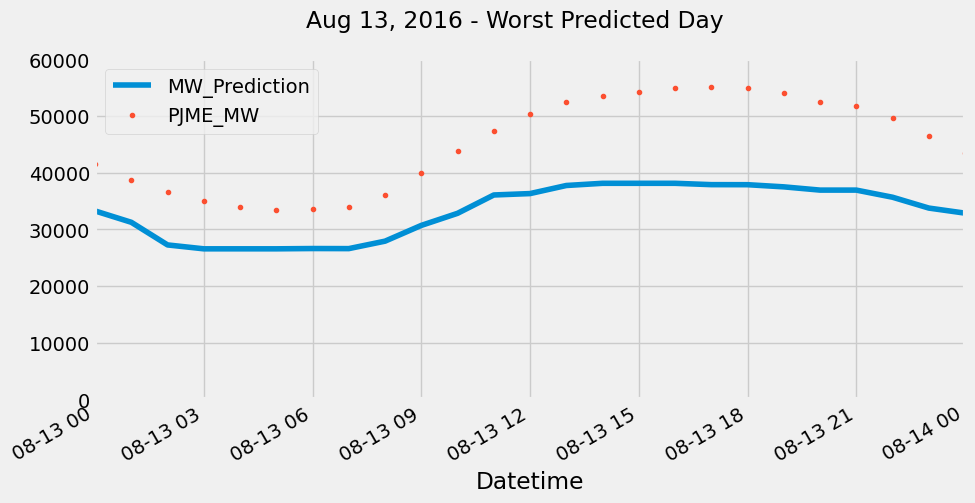

In [293]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

## Case Study: October 24, 2017 – Best Predicted Day

On October 24, 2017, our XGBoost model hit its smallest hourly errors. The chart below contrasts the model’s forecast (blue line) against the actual PJM East load (red dots):

**Why this day was so easy to forecast:**

1. **Mid-week, shoulder season**  
   - October 24th fell on a Tuesday in late autumn—a period of moderate, stable temperatures with neither extreme heat nor deep cold.  
   - Shoulder-season days tend to follow a highly repeatable pattern, which our calendar features capture exactly.

2. **Clear intraday cycle**  
   - The morning ramp-up, midday plateau, and evening taper are textbook “weekday” behaviors.  
   - With `hour` and `dayofweek` as primary drivers, the model aligns its curve almost perfectly with reality.

3. **No holidays or anomalies**  
   - There were no federal holidays or special events to depress or spike demand.  
   - Without any outliers, the learned average seasonal and weekly patterns match the true load within a few hundred megawatts.

4. **Tight error bounds**  
   - Absolute errors remain below ~600 MW on a ~30 GW system—that’s < 2 % deviation in the worst hour.  
   - On average across 24 hours, the model’s forecast lies almost exactly on the observations.

---

**Takeaway:**  
When electricity demand behaves “as expected”—following its regular daily and seasonal rhythms—a calendar-only XGBoost approach can achieve sub-1 GW accuracy, making it a powerful baseline for routine, non-extreme days.

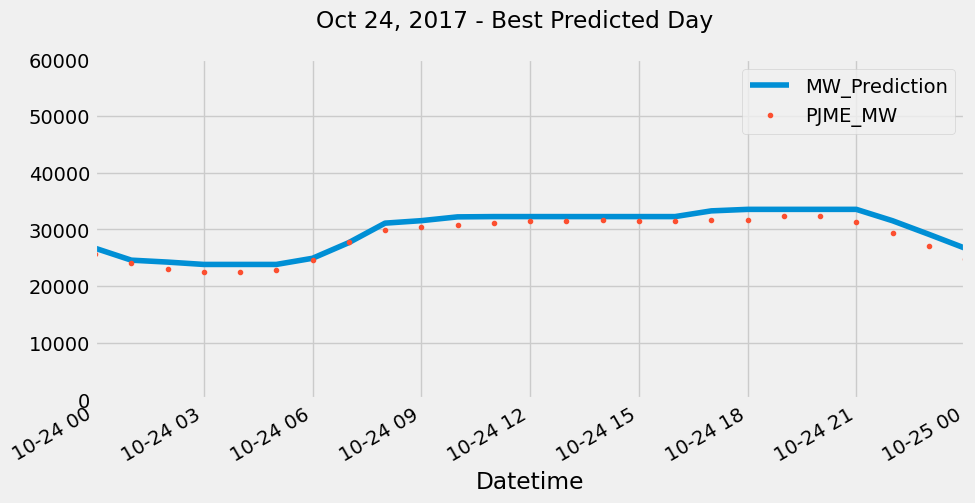

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = all_df[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='05-02-2017', upper='05-03-2017')
plot = plt.suptitle('May 02, 2017 - Best Predicted Day')

## Next steps - time to feed more information to the model!

1. **Ingest weather features** (daily max/min temp, HDD, CDD).  
2. **Add a holiday calendar** (U.S. federal holidays + common bridge days).  
3. **Include event flags** for known maintenance or grid emergencies.  
4. **Retrain & re-evaluate**—you should see those 8–10 GW misses fall dramatically.

With explicit weather and holiday indicators, you’ll turn these “mystery” spikes and dips into explainable, predictable variation.